In [110]:
from collections import Counter 
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import re
import networkx as nx

In [118]:
# load the data
import pickle
import pandas as pd
import datetime as dt

file = open(f'data/SCMP/all.pkl', 'rb')
texts = pickle.load(file)
file.close()

df = pd.read_csv('data/SCMP/metadata.csv', parse_dates=['date'])

In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255 entries, 0 to 254
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  255 non-null    int64  
 1   title       255 non-null    object 
 2   body        255 non-null    object 
 3   words       255 non-null    float64
 4   date        255 non-null    object 
dtypes: float64(1), int64(1), object(3)
memory usage: 10.1+ KB


In [4]:
# load the stanza lemmatizer
import stanza
nlp = stanza.Pipeline(lang='en', processors='tokenize,mwt,pos,lemma')

# list of stop words with less semantic value
stop_words = [line.replace('\n','') for line in open("stopwords.txt", "r").readlines()]
stop_words[:5]

2024-03-20 01:59:39 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-03-20 01:59:40 INFO: Loading these models for language: en (English):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| mwt       | combined          |
| pos       | combined_charlm   |
| lemma     | combined_nocharlm |

2024-03-20 01:59:40 INFO: Using device: cpu
2024-03-20 01:59:40 INFO: Loading: tokenize
2024-03-20 01:59:40 INFO: Loading: mwt
2024-03-20 01:59:40 INFO: Loading: pos
2024-03-20 01:59:40 INFO: Loading: lemma
2024-03-20 01:59:40 INFO: Done loading processors!


['in', 'the', ',', 'to', 'and']

In [5]:
# function to lemmatize texts with the processor
def lemma(list_of_texts):
    
    lemmas = []
    
    for text in list_of_texts:
        doc = nlp(text)
        lemmas += [word.lemma for sent in doc.sentences for word in sent.words]
        
    return lemmas

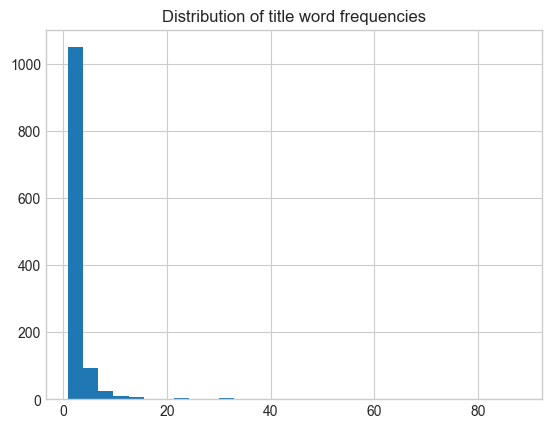

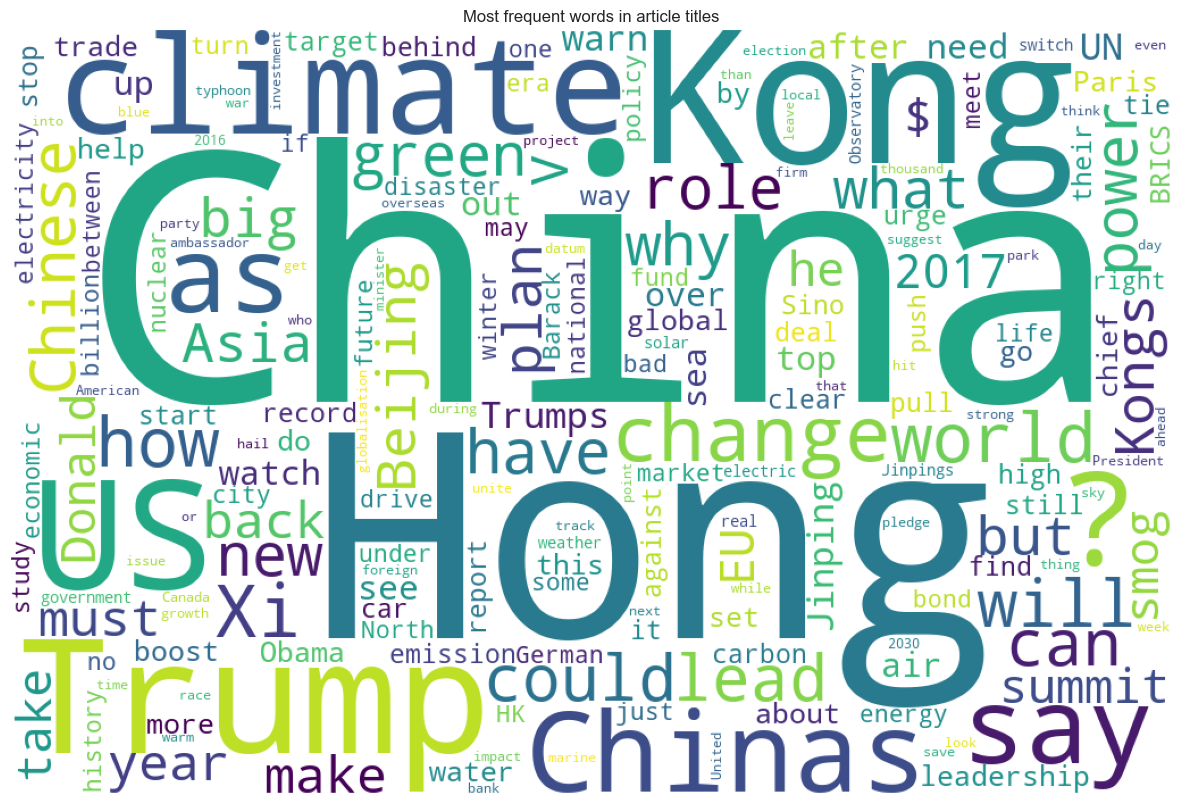

In [11]:
'''
Explore articles' content based on lemmatized words in title and body text of articles
'''

# title texts

#####################
# The code takes a while to complete due to lemmatization 

# title_lemmas = lemma(df.title)
# title_lemmas = [lemma for lemma in title_lemmas if lemma not in stop_words]

# c = Counter(title_lemmas)
# wc_data = {x: count for x, count in c.items() if count >= 3}
#####################

plt.style.use('seaborn-v0_8-whitegrid')

#distribution of word frequencies
freq_of_freq = [count for x, count in c.items()]
plt.hist(freq_of_freq, bins = 30)
plt.title('Distribution of title word frequencies')
plt.show()

#wordcloud
wordcloud = WordCloud(background_color="white", 
                      width=1024, 
                      height=674).generate_from_frequencies(wc_data)

plt.figure(figsize=(15,12))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Most frequent words in article titles')
plt.show()

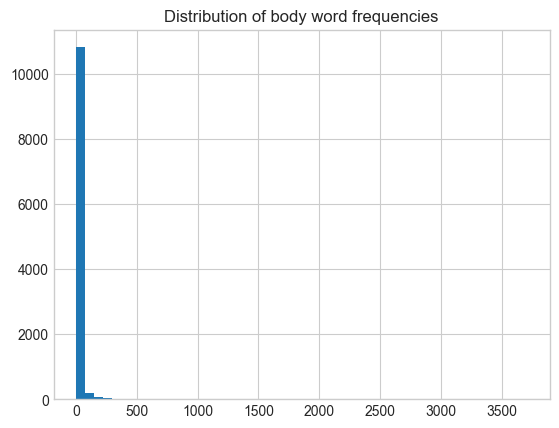

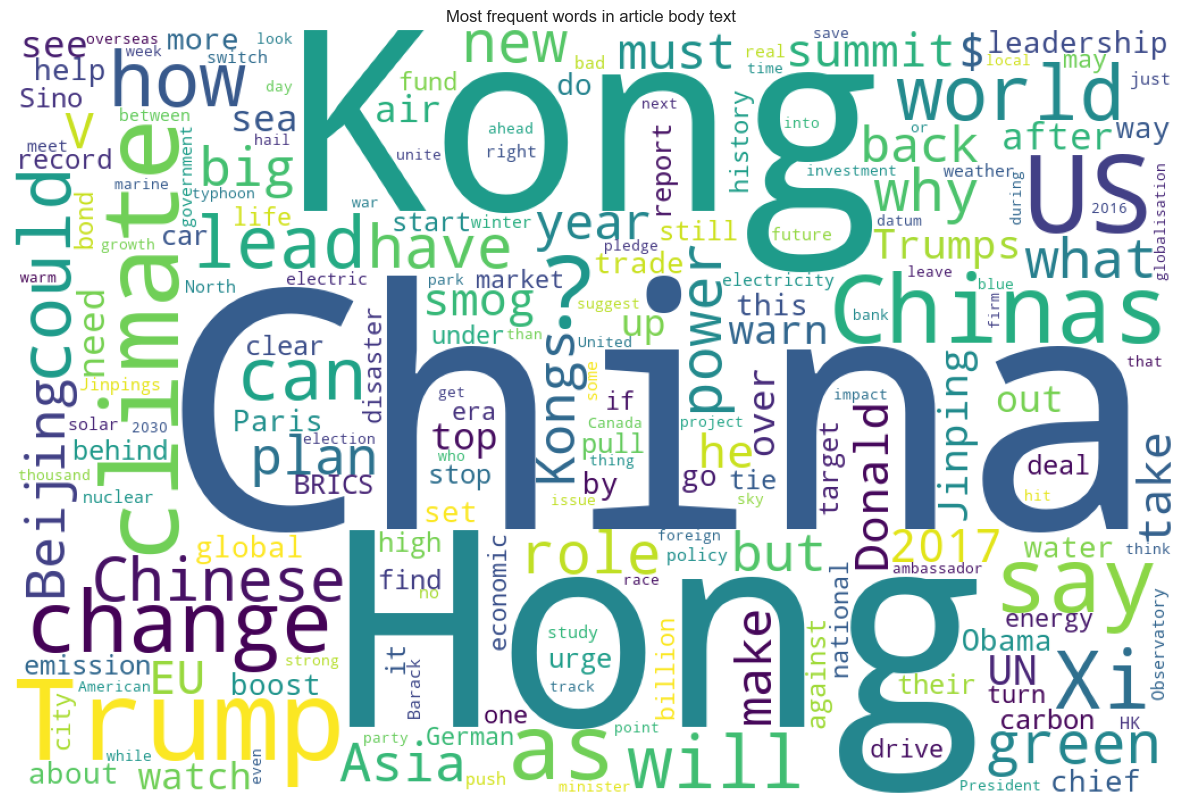

In [12]:
# body texts

#####################
# The code takes a while to complete due to lemmatization 

# body_lemmas = lemma(df.body)
# body_lemmas = [lemma for lemma in body_lemmas if lemma not in stop_words]

# c = Counter(body_lemmas)
# wc_data_01 = {x: count for x, count in c.items() if count >= 3}
#####################

plt.style.use('seaborn-v0_8-whitegrid')

#distribution of word frequencies
freq_of_freq = [count for x, count in c.items()]
plt.hist(freq_of_freq, bins = 50)
plt.title('Distribution of body word frequencies')
plt.show()

#wordcloud
wordcloud = WordCloud(background_color="white", 
                      width=1024, 
                      height=674).generate_from_frequencies(wc_data)

plt.figure(figsize=(15,12))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Most frequent words in article body text')
plt.show()

In [5]:
'''
Explore articles' content based on given labels
'''

# A function to extract labels for articles from texts 

def extract_label(txts, search):
    
    labels = []
    labels_weight = []

    for txt in txts:
        
        m = re.search(fr'{search}:\xa0(.*)', txt)
        
        if m == None:
            labels_weight.append([])
        
        else:
            label_list = m.group(1).split('; ')
            keys = []
            values = []
            
            for label in label_list:
                
                key = re.search(r'(.*) \(', label)
                value = re.search(r'(\d+)%', label)
                keys.append(key.group(1))
                labels.append(key.group(1))
                values.append(float(value.group(1)))
            
            add_labels_weight = list(zip(keys, values))
                
            labels_weight.append(add_labels_weight)
        
    return labels, labels_weight

# Constructing network: edges (connections) between labels and articles

def label2edge(labels_weight, labels, freq_cutoff, weight_cutoff, attr):
    c = Counter(labels)
    edgelist = pd.DataFrame(data = [], columns=['article', 'label', 'weight', 'attr'])
    
    for i, article in enumerate(labels_weight):
        for item in article:
            if c[item[0]] <= freq_cutoff or item[1] <= weight_cutoff:
                article.remove(item)
            else:
                edge = pd.Series([i, item[0], item[1]/100, attr], index=['article', 'label', 'weight', 'attr'])
                edgelist = pd.concat([edgelist, edge.to_frame().T])
    return edgelist

In [6]:
# Three types of label are extracted: Subject, Industry and Geographic

subs, subw = extract_label(texts, "Subject")
inds, indw = extract_label(texts, "Industry")
geos, geow = extract_label(texts, "Geographic")

# Only use labels which appear more than 20 times and are predicted with over 80% confidence 
freq_cutoff = 20
weight_cutoff = 80

subed = label2edge(subw, subs, freq_cutoff, weight_cutoff, 'subject')
inded = label2edge(indw, inds, freq_cutoff, weight_cutoff, 'industry')
geoed = label2edge(geow, geos, freq_cutoff, weight_cutoff, 'geography')

print(f'The number of labels to be used in analysis is:\n{len(subed)} (subjects, {len(set(subed.label))} unique) + {len(inded)} (industries, {len(set(inded.label))} unique) + {len(geoed)} (geolocations, {len(set(geoed.label))} unique) = {len(subed) + len(inded) + len(geoed)}')

# dataframe for edges between articles and labels
label_article_edges = pd.concat([subed, inded, geoed])
display(label_article_edges)

The number of labels to be used in analysis is:
803 (subjects, 58 unique) + 100 (industries, 10 unique) + 464 (geolocations, 17 unique) = 1367


article                              label weight       attr
0        1  POLLUTION & ENVIRONMENTAL IMPACTS   0.89    subject
0        3                         AGREEMENTS    0.9    subject
0        3        HEADS OF STATE & GOVERNMENT    0.9    subject
0        3                INTERNATIONAL TRADE    0.9    subject
0        3                   TALKS & MEETINGS    0.9    subject
..     ...                                ...    ...        ...
0      250                              CHINA   0.95  geography
0      251                          HONG KONG   0.93  geography
0      252                     BEIJING, CHINA   0.88  geography
0      252                      UNITED STATES   0.93  geography
0      253                          HONG KONG   0.92  geography

[1367 rows x 4 columns]

Text(0.5, 1.0, 'Distribution of label frequencies (monthly average)')

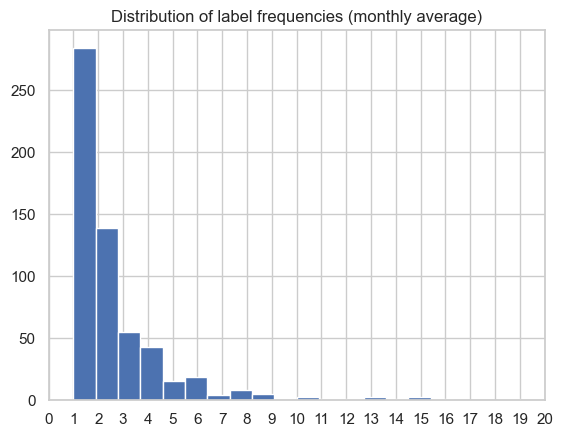

In [341]:
"""
Overview of labels in the network
Check frequencies to identify important labels
"""

article_date = dict(df.date)
label_article_edges['date'] = label_article_edges.apply(lambda x: article_date[x.article], axis = 1)

data = label_article_edges.groupby(by = [pd.Grouper(key='date', freq='M'), 'label']).count().reset_index().sort_values(by = 'article', ascending = False)
plt.hist(data.article, bins = 20)
plt.xticks(np.arange(0, 21, step=1))
plt.title('Distribution of label frequencies (monthly average)')

Top 10 most common labels and their occurences over time


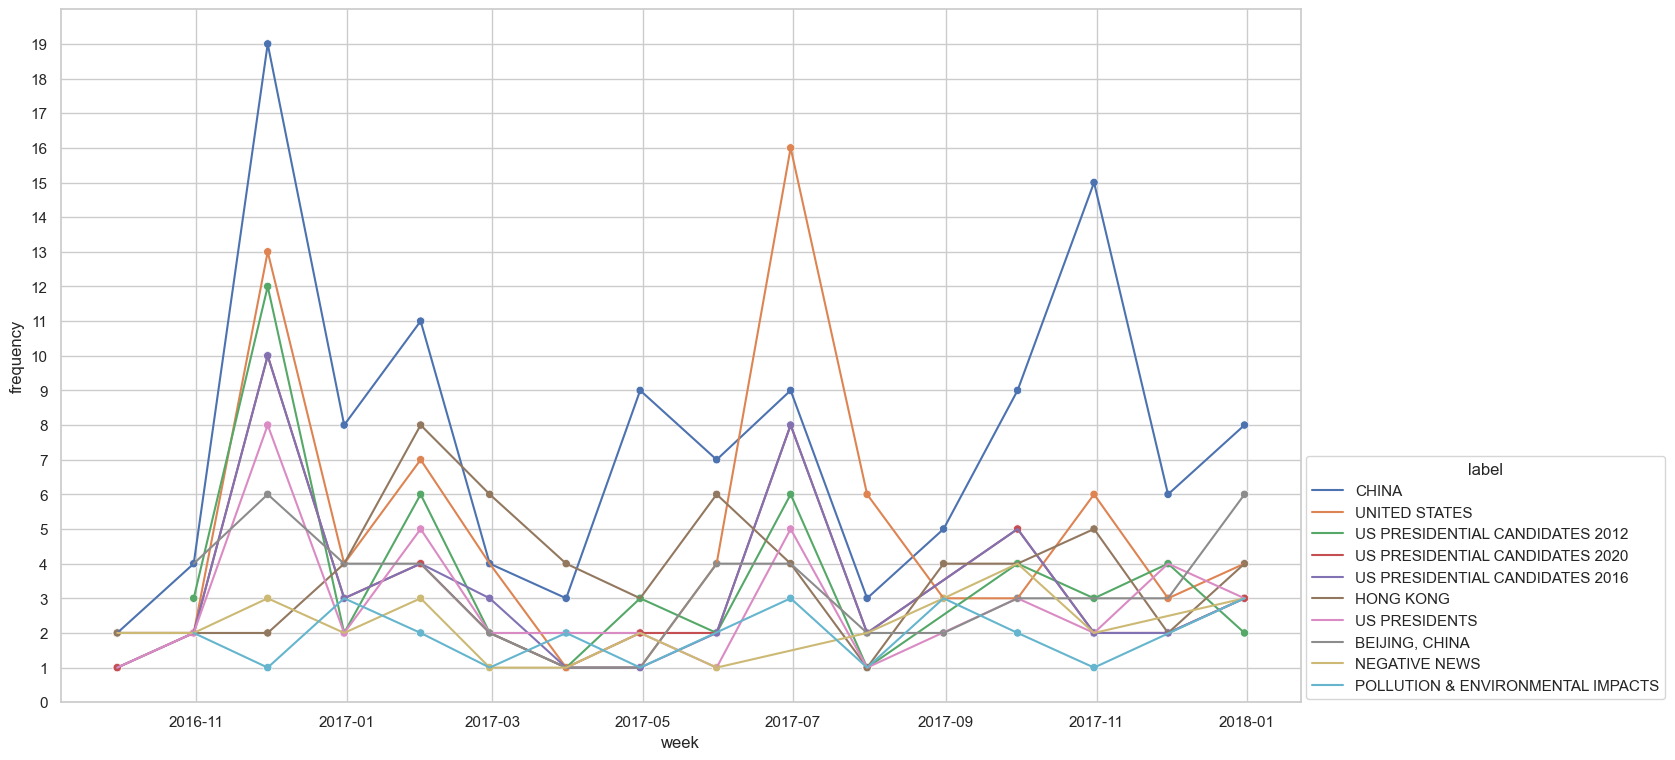

In [374]:
top_10 = list(data.groupby('label').count().reset_index().sort_values(by = 'article', ascending = False)[:10].label)

sns.set_theme(style="whitegrid")
print("Top 10 most common labels and their occurences over time")
plt.figure(figsize=(16, 9))
ax = sns.lineplot(data=data[data.label.isin(top_10)], x="date", y="article", hue="label")
sns.scatterplot(data=data[data.label.isin(top_10)], x="date", y="article", hue="label", legend=False)
ax.set(xlabel='week', ylabel='frequency')
ax.set_ylim(0, 20)
ax.set(yticks=range(20))
sns.move_legend(ax, "center right", bbox_to_anchor=(1.3, 0.18))

Top 10-20 most common labels and their occurences over time


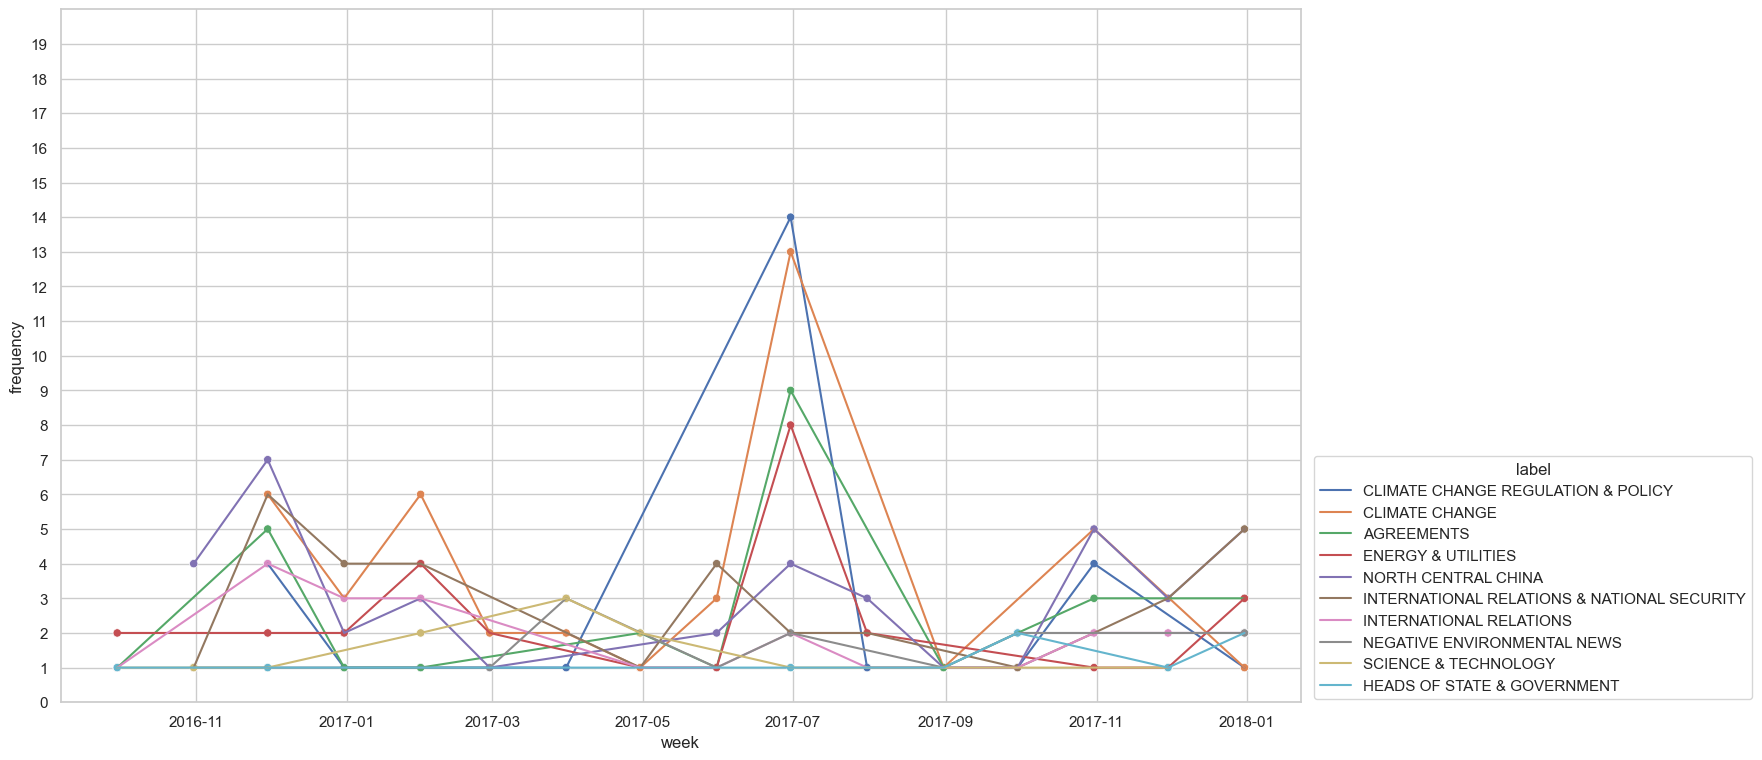

In [376]:
print("Top 10-20 most common labels and their occurences over time")
top_1020 = list(data.groupby('label').count().reset_index().sort_values(by = 'article', ascending = False)[10:20].label)

plt.figure(figsize=(16, 9))
ax = sns.lineplot(data=data[data.label.isin(top_1020)], x="date", y="article", hue="label")
sns.scatterplot(data=data[data.label.isin(top_1020)], x="date", y="article", hue="label", legend=False)
ax.set(xlabel='week', ylabel='frequency')
ax.set_ylim(0, 20)
ax.set(yticks=range(20))
sns.move_legend(ax, "center right", bbox_to_anchor=(1.37, 0.18))

Top 20-30 most common labels and their occurences over time


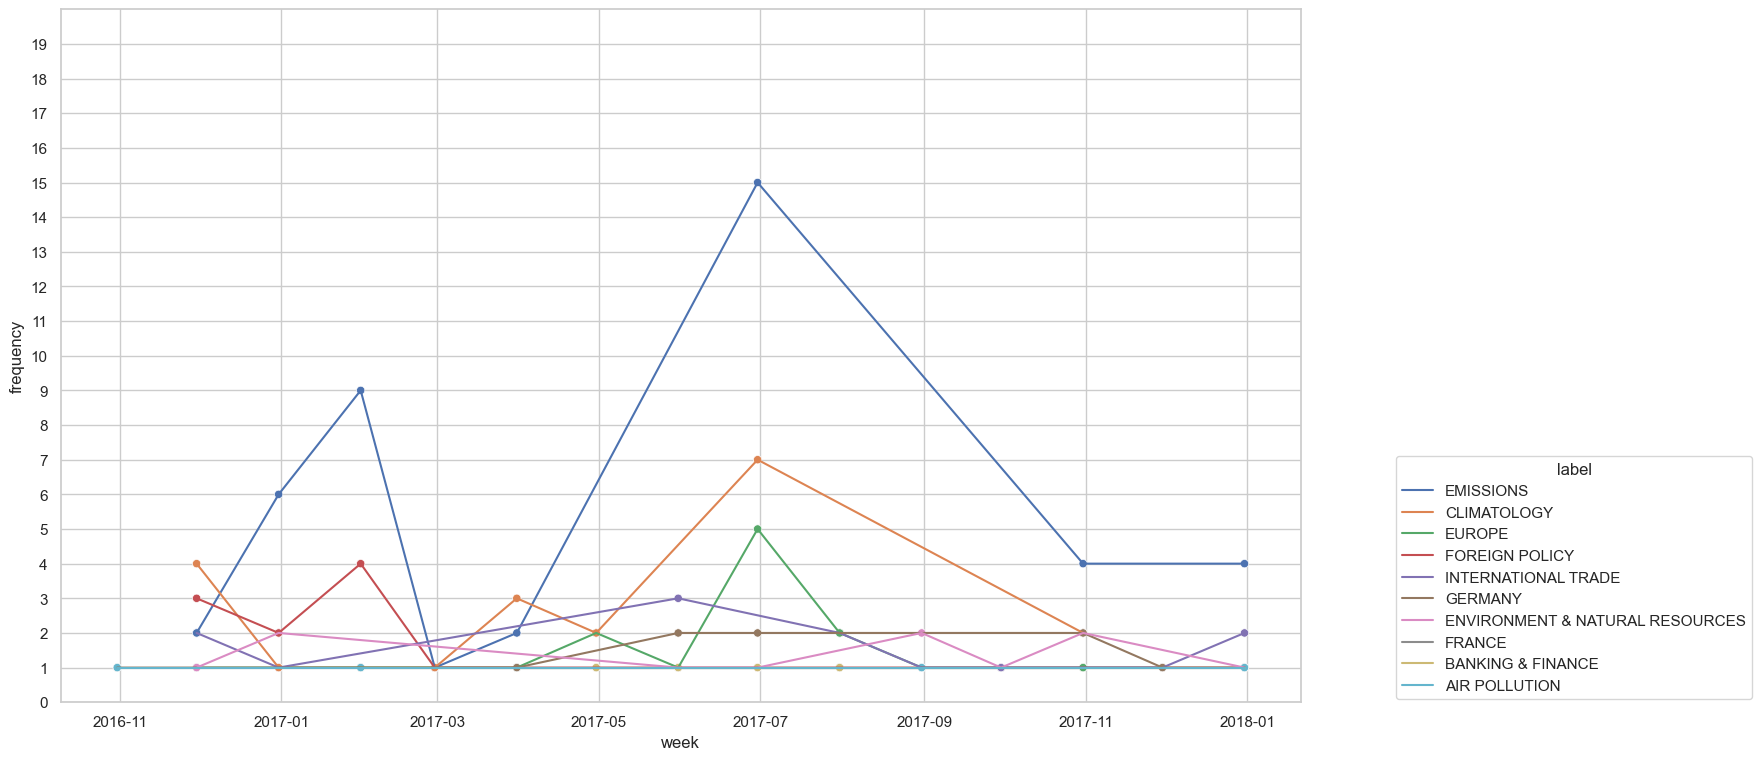

In [377]:
print("Top 20-30 most common labels and their occurences over time")
top_2030 = list(data.groupby('label').count().reset_index().sort_values(by = 'article', ascending = False)[20:30].label)

plt.figure(figsize=(16, 9))
ax = sns.lineplot(data=data[data.label.isin(top_2030)], x="date", y="article", hue="label")
sns.scatterplot(data=data[data.label.isin(top_2030)], x="date", y="article", hue="label", legend=False)
ax.set(xlabel='week', ylabel='frequency')
ax.set_ylim(0, 20)
ax.set(yticks=range(20))
sns.move_legend(ax, "center right", bbox_to_anchor=(1.37, 0.18))

In [7]:
node_attr = {}
for node in label_article_edges.article:
    node_attr[node] = 0
for node in label_article_edges.label[:803]:
    node_attr[node] = 1
for node in label_article_edges.label[803:903]:
    node_attr[node] = 2
for node in label_article_edges.label[903:]:
    node_attr[node] = 3

In [207]:
import numpy as np
import matplotlib.pyplot as plt
embeddings = np.array(list(pos.values()))

Label-article network (1/2)


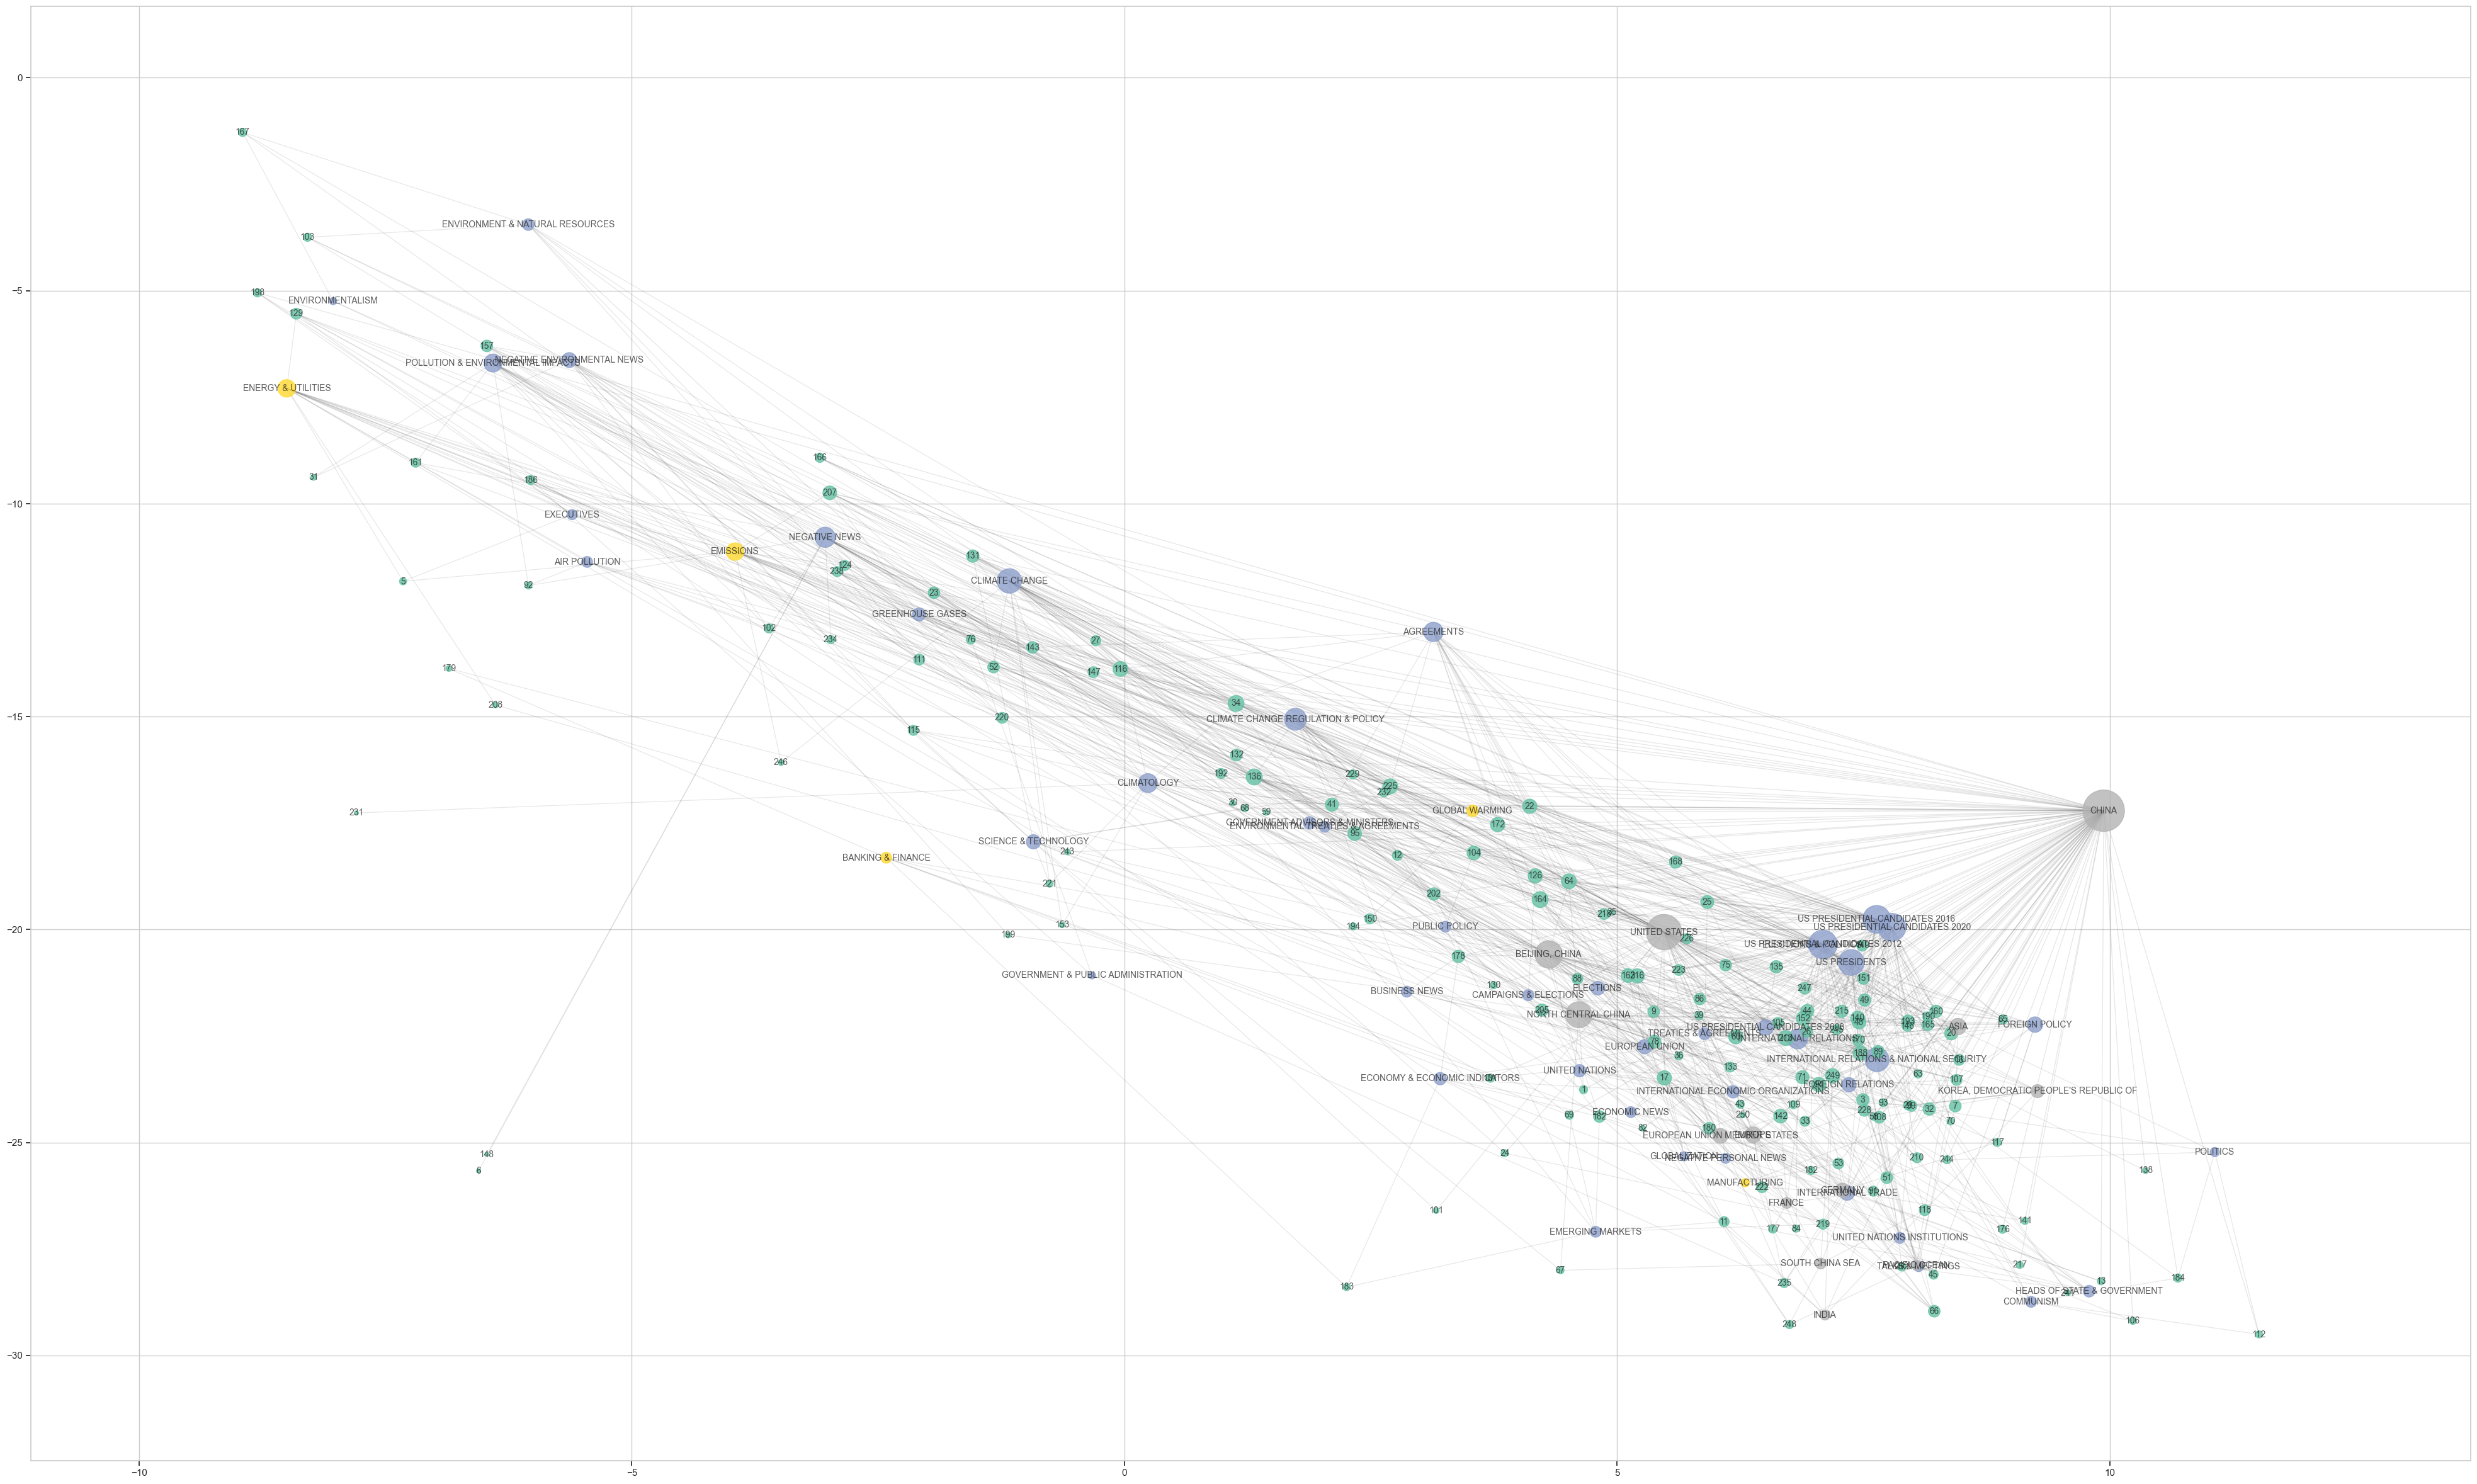

In [378]:
G=nx.from_pandas_edgelist(label_article_edges, 'article', 'label', ['weight', 'attr'])
nx.set_node_attributes(G, node_attr, "type")
pos = nx.spectral_layout(G, weight='weight', scale = 1000)

print("Label-article network (1/2)")
pos_nooutlier = {}
outlier = []
for item in pos:
    if pos[item][0] < 20 and pos[item][0] > -10 and pos[item][1] < 0 and pos[item][1] > -30:
        pos_nooutlier[item] = pos[item]
    else:
        outlier.append(item)

cmap = plt.cm.Set2

H = G.copy()
H.remove_nodes_from(outlier)

node_deg = [deg*5000 for deg in nx.degree_centrality(H).values()]
node_type =  nx.get_node_attributes(H, 'type')
node_color = [node_type[node] for node in node_type if node not in outlier]
edge_width = list(nx.get_edge_attributes(H, 'weight').values())

fig, ax = plt.subplots(figsize=(50, 30))

nx.draw_networkx_edges(H, pos_nooutlier, alpha=0.1, width=edge_width*100)
nx.draw_networkx_nodes(H, pos_nooutlier, node_size=node_deg, node_color=node_color, cmap=cmap, alpha=0.8, ax=ax)
nx.draw_networkx_labels(H, pos_nooutlier, font_size=10, alpha=0.7, ax=ax)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

Label-article network (2/2)


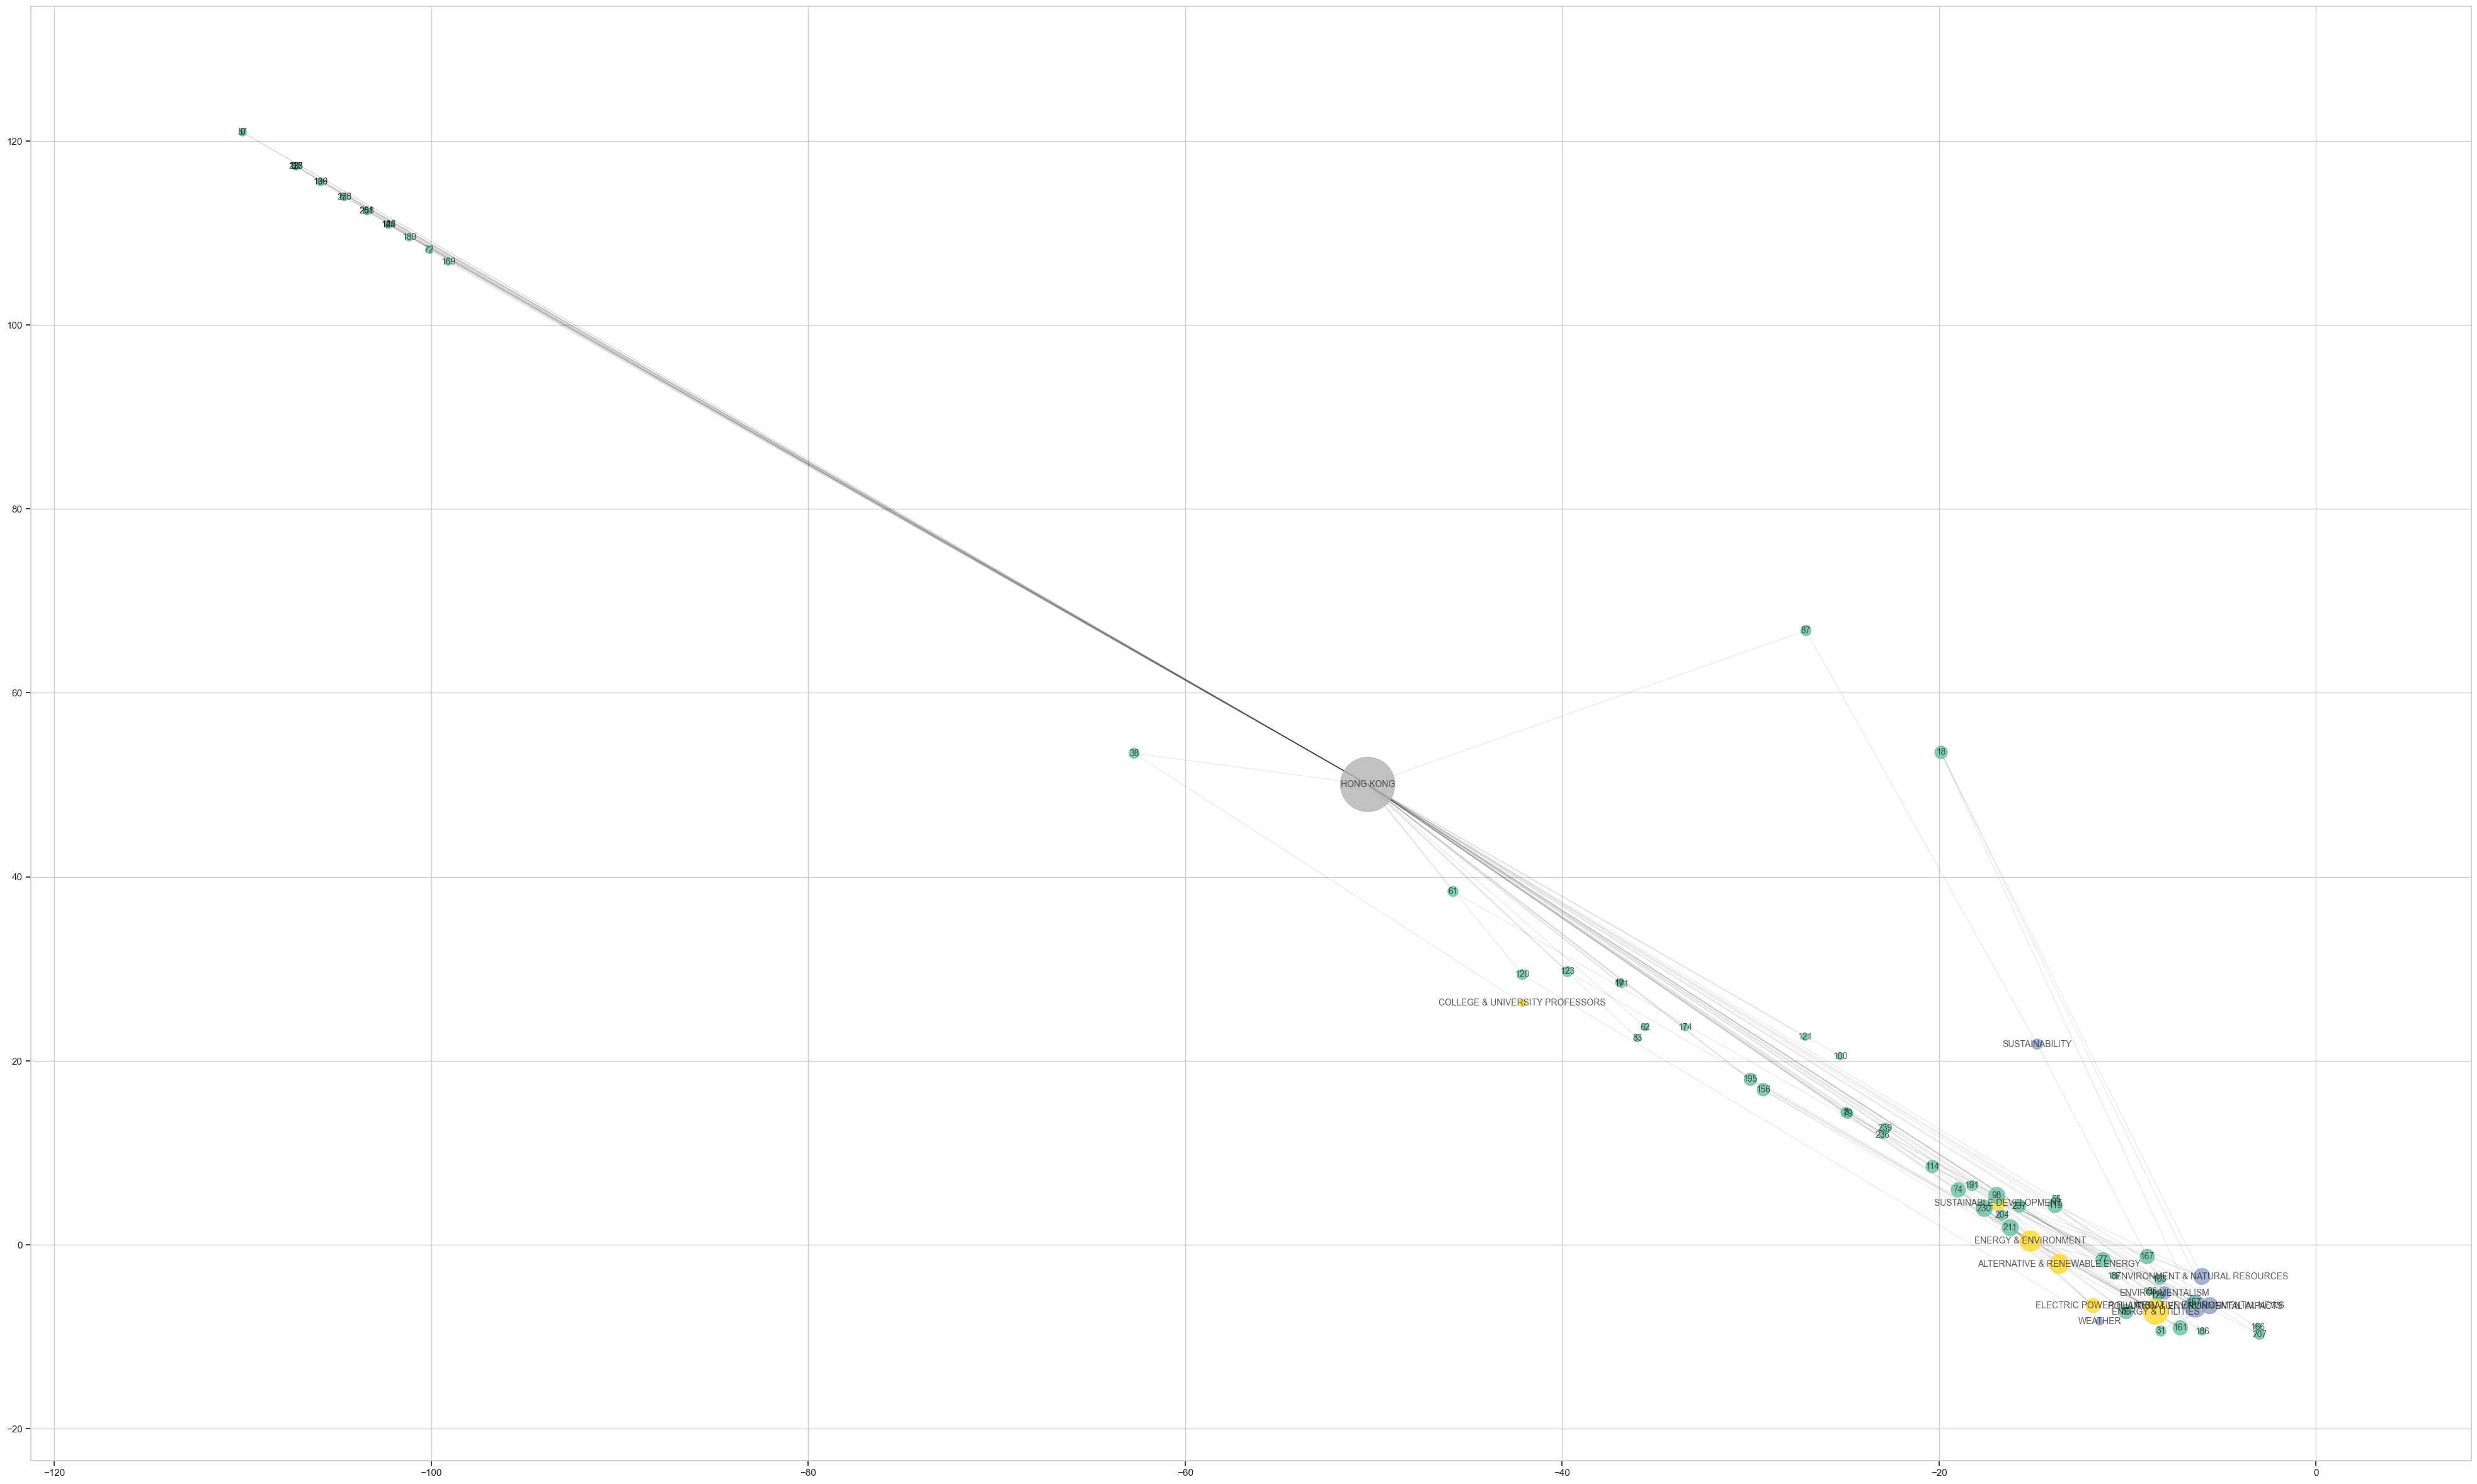

In [379]:
print("Label-article network (2/2)")
pos_nooutlier = {}
outlier = []
for item in pos:
    if pos[item][0] < 0 and pos[item][0] > -200 and pos[item][1] < 200 and pos[item][1] > -10:
        pos_nooutlier[item] = pos[item]
    else:
        outlier.append(item)
        
H = G.copy()
H.remove_nodes_from(outlier)

node_deg = [deg*5000 for deg in nx.degree_centrality(H).values()]
node_type =  nx.get_node_attributes(H, 'type')
node_color = [node_type[node] for node in node_type if node not in outlier]
edge_width = list(nx.get_edge_attributes(H, 'weight').values())

fig, ax = plt.subplots(figsize=(50, 30))

nx.draw_networkx_edges(H, pos_nooutlier, alpha=0.1, width=edge_width*100)
nx.draw_networkx_nodes(H, pos_nooutlier, node_size=node_deg, node_color=node_color, cmap=cmap, alpha=0.8, ax=ax)
nx.draw_networkx_labels(H, pos_nooutlier, font_size=10, alpha=0.7, ax=ax)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)